Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, ConfusionMatrixDisplay
from evaluate import plot_confusion_matrix, plot_feature_importance, plot_parameter_sensitivity, get_results, get_cross_validation_scores
from preprocess import prepare_loan_train_test, preprocess_loan_features
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from scipy.stats import loguniform
from sklearn.model_selection import train_test_split
import time
import matplotlib.pylab as plt
import seaborn as sns

## BaseModel

In [2]:
training_data = pd.read_csv("loan-10k.lrn.csv") 
training_data = preprocess_loan_features(training_data)
X_train, X_val, y_train, y_val = prepare_loan_train_test(training_data, scale=True)

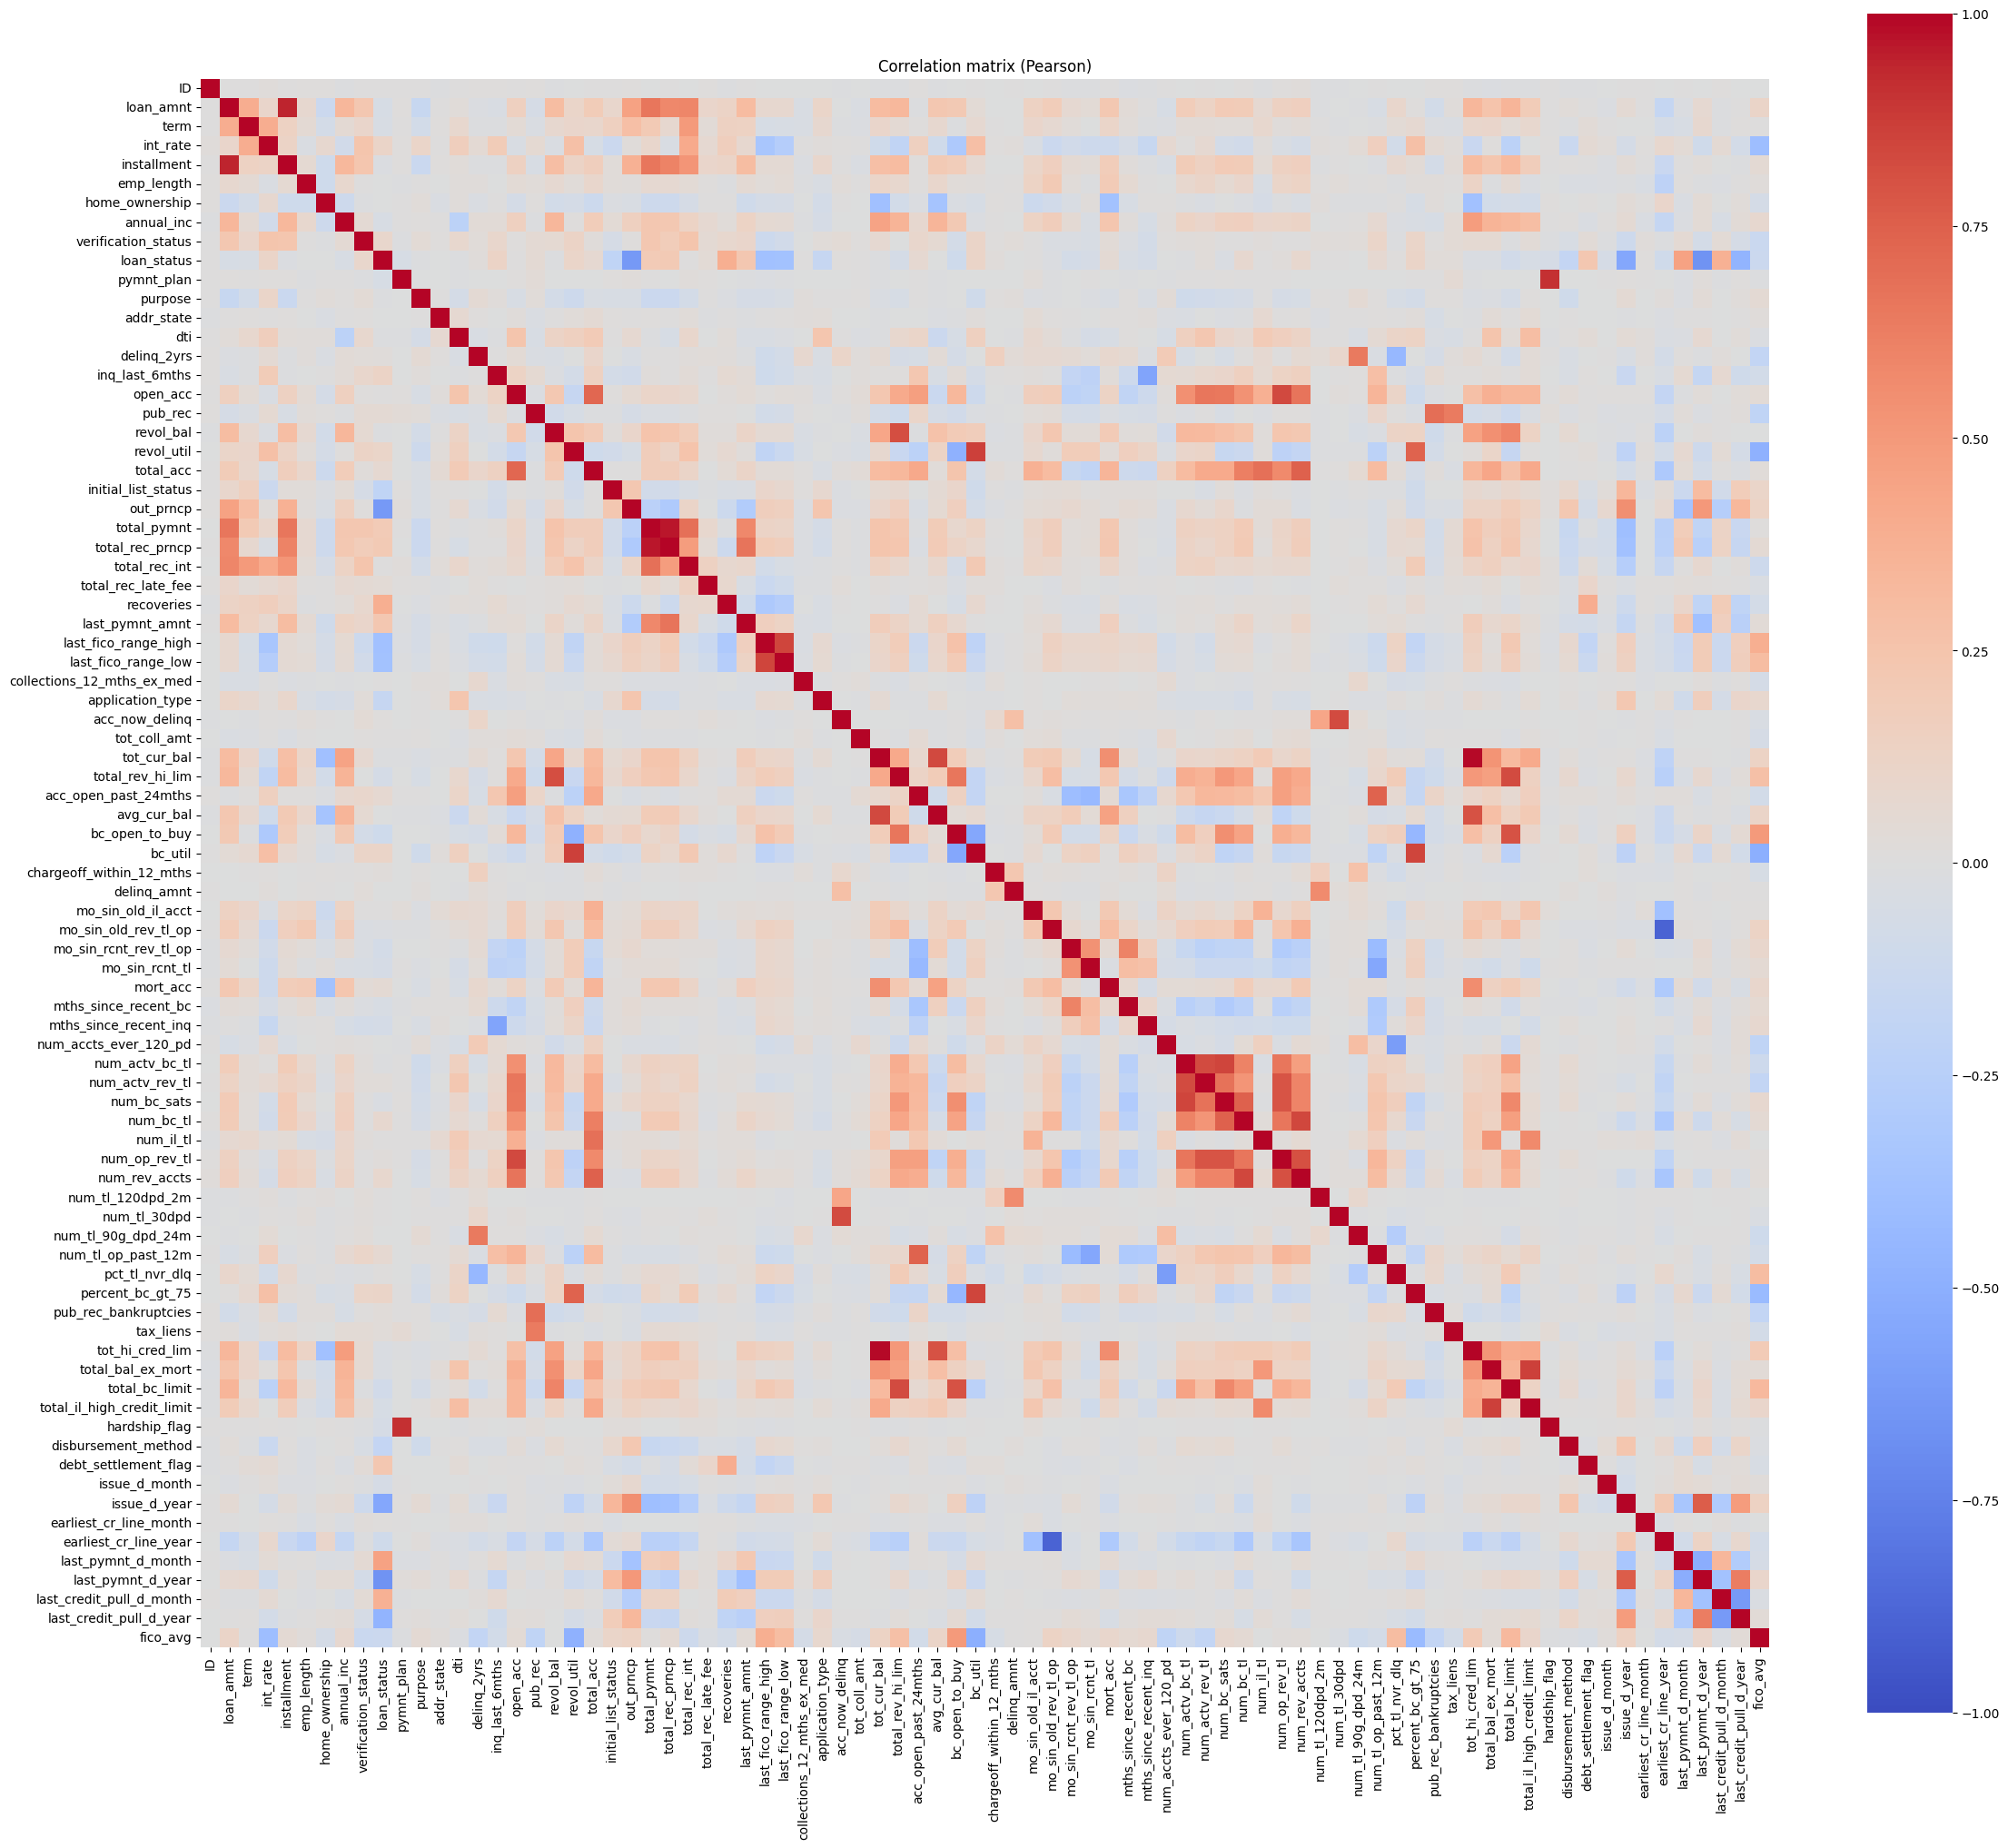

In [3]:
df = training_data.copy()
corr = df.corr(numeric_only=True, method='pearson')
plt.figure(figsize=(max(8, min(24, 0.35 * corr.shape[1])), 
                    max(8, min(24, 0.35 * corr.shape[0]))))
sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap='coolwarm',
            square=True, xticklabels=True, yticklabels=True,
            cbar_kws={'shrink': 0.8})
plt.title('Correlation matrix (Pearson)')
plt.tight_layout()
plt.show()

In [4]:
abs_corr = corr.abs()
upper = abs_corr.where(np.triu(np.ones(abs_corr.shape), k=1).astype(bool))

top_pairs = (
    upper.stack()
         .sort_values(ascending=False)
         .rename('abs_corr')
         .reset_index()
         .rename(columns={'level_0':'feature_1','level_1':'feature_2'})
)
top_pairs['pearson_r'] = top_pairs.apply(
    lambda r: corr.loc[r['feature_1'], r['feature_2']], axis=1
)

top5 = top_pairs.loc[:, ['feature_1','feature_2','pearson_r','abs_corr']].head(20)
display(top5.style.format({'pearson_r':'{:.3f}', 'abs_corr':'{:.3f}'}))

,feature_1,feature_2,pearson_r,abs_corr
0,tot_cur_bal,tot_hi_cred_lim,0.985,0.985
1,total_pymnt,total_rec_prncp,0.966,0.966
2,loan_amnt,installment,0.944,0.944
3,pymnt_plan,hardship_flag,0.913,0.913
4,mo_sin_old_rev_tl_op,earliest_cr_line_year,-0.891,0.891
5,revol_util,bc_util,0.863,0.863
6,total_bal_ex_mort,total_il_high_credit_limit,0.861,0.861
7,last_fico_range_high,last_fico_range_low,0.851,0.851
8,bc_util,percent_bc_gt_75,0.847,0.847
9,num_actv_bc_tl,num_bc_sats,0.845,0.845


              precision    recall  f1-score   support

           A       0.39      0.88      0.54       364
           B       0.50      0.34      0.41       576
           C       0.59      0.32      0.42       598
           D       0.52      0.17      0.26       290
           E       0.26      0.27      0.26       124
           F       0.08      0.30      0.12        37
           G       0.07      0.64      0.13        11

    accuracy                           0.41      2000
   macro avg       0.34      0.42      0.31      2000
weighted avg       0.49      0.41      0.40      2000



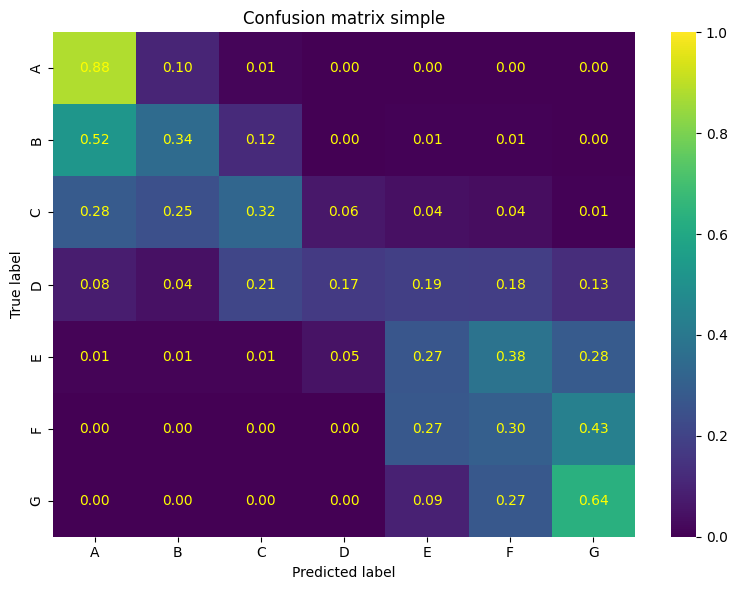

In [4]:
target_names = ["A","B", "C", "D", "E", "F", "G"]
ridge_model = RidgeClassifier(class_weight= 'balanced',random_state=42)
ridge_model.fit(X_train, y_train)

y_pred_ridge = ridge_model.predict(X_val)

get_results(y_val, y_pred_ridge, target_names)

## Base model without estimating intercept


              precision    recall  f1-score   support

           A       0.39      0.88      0.54       364
           B       0.51      0.34      0.41       576
           C       0.58      0.32      0.42       598
           D       0.52      0.17      0.26       290
           E       0.27      0.27      0.27       124
           F       0.08      0.32      0.13        37
           G       0.07      0.64      0.13        11

    accuracy                           0.41      2000
   macro avg       0.35      0.42      0.31      2000
weighted avg       0.49      0.41      0.40      2000



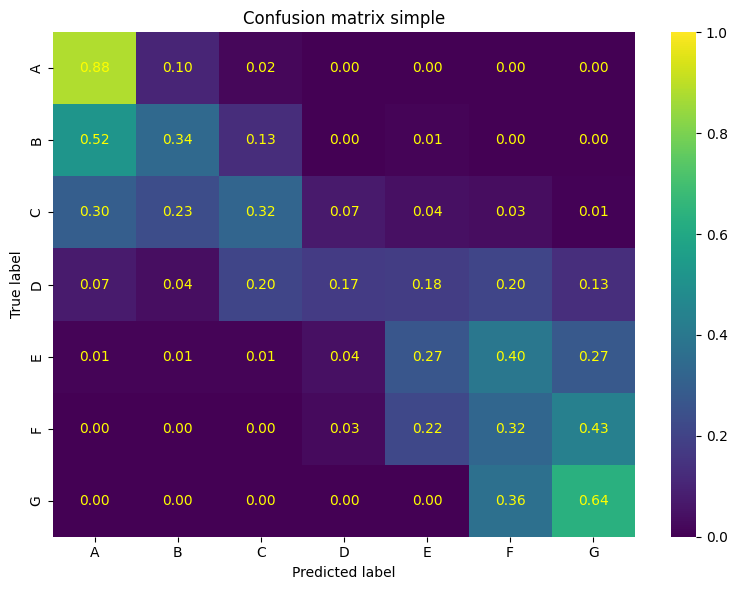

In [5]:
ridge_model_nointercept = RidgeClassifier(class_weight= 'balanced', fit_intercept= False, random_state=42)
ridge_model_nointercept.fit(X_train, y_train)

y_pred_ridge = ridge_model_nointercept.predict(X_val)

get_results(y_val, y_pred_ridge, target_names)

## Base model cross-val scores and hyperparam optimalization

In [6]:
get_cross_validation_scores(ridge_model, X_train, y_train )

10-Fold CV Scores: [0.39880681 0.38281442 0.38474828 0.39667326 0.38891605 0.38549295
 0.35835833 0.38926325 0.38412734 0.37602   ]
Average f1_weighted Score: 0.3845
Standard Deviation: 0.0107


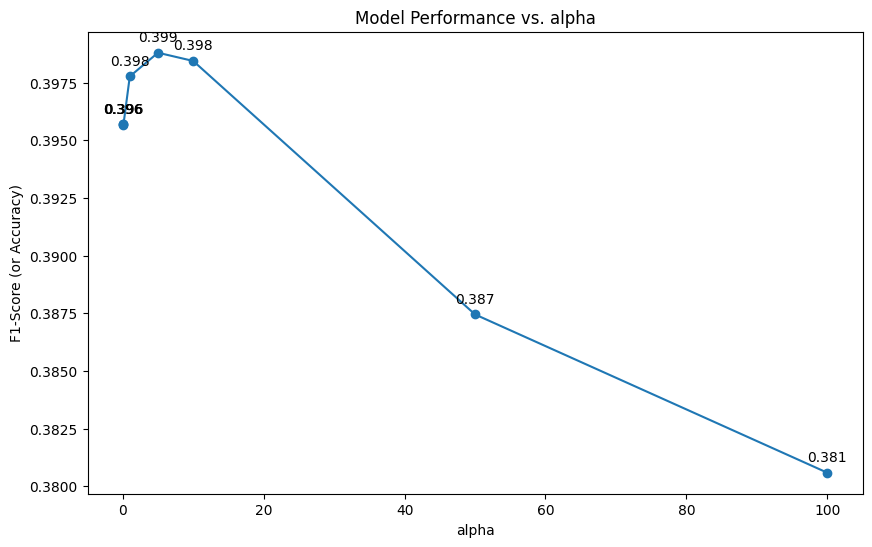

Alpha Values Tested: [0.001, 0.01, 0.1, 1.0, 5.0, 10.0, 50.0, 100.0]
Weighted F1 Scores: ['0.3957', '0.3957', '0.3957', '0.3978', '0.3988', '0.3984', '0.3875', '0.3806']


In [7]:
f1_scores_ridge = []
param_range = [0.001, 0.01, 0.1, 1.0, 5.0, 10.0, 50.0, 100.0]
# Iterate through the alpha values
for alpha_val in param_range:
    # Instantiate the RidgeClassifier with the current alpha
    ridge_exp = RidgeClassifier(
        alpha=alpha_val,  # Set the current alpha value
        class_weight='balanced',
        random_state=42
    )
    
    # Train the model
    ridge_exp.fit(X_train, y_train)
    
    # Generate the classification report
    report = classification_report(
        y_val, 
        ridge_exp.predict(X_val), 
        output_dict=True
    )
    
    # Store the weighted F1-score
    f1_scores_ridge.append(report['weighted avg']['f1-score'])

# 3. Plot the results
# The plotting logic is simpler for Ridge as there's no 'None' value
plot_parameter_sensitivity(
    param_values=param_range, 
    scores=f1_scores_ridge, 
    param_name="alpha"
)

# Optional: Print results
print("Alpha Values Tested:", param_range)
print("Weighted F1 Scores:", [f"{score:.4f}" for score in f1_scores_ridge])

In [12]:

index_name = 'model_name'
column_name = 'randsearch_time'

df_times = pd.DataFrame(
    index = pd.Index([], name=index_name),
    columns = [column_name],
    dtype = np.float64
)

model_name = 'ridge_weights'

# Parameters to optimize
param_distributions = {
    'alpha': loguniform(1e-3, 1),
}


random_search = RandomizedSearchCV(
    estimator=ridge_model,
    param_distributions=param_distributions,
    n_iter=50,  
    cv=5,     
    scoring='f1_weighted',
    random_state=42,
    n_jobs=-1
)

start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time

df_times.loc[model_name, column_name] = training_time
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best F1-score: {random_search.best_score_:.4f}")

final_model = random_search.best_estimator_

Best parameters found: {'alpha': np.float64(0.8123245085588685)}
Best F1-score: 0.3791


Optimal alpha: 0.8123245085588685


              precision    recall  f1-score   support

           A       0.39      0.88      0.54       364
           B       0.49      0.35      0.41       576
           C       0.59      0.32      0.41       598
           D       0.52      0.16      0.25       290
           E       0.26      0.24      0.25       124
           F       0.09      0.32      0.14        37
           G       0.07      0.64      0.13        11

    accuracy                           0.40      2000
   macro avg       0.34      0.42      0.30      2000
weighted avg       0.48      0.40      0.39      2000



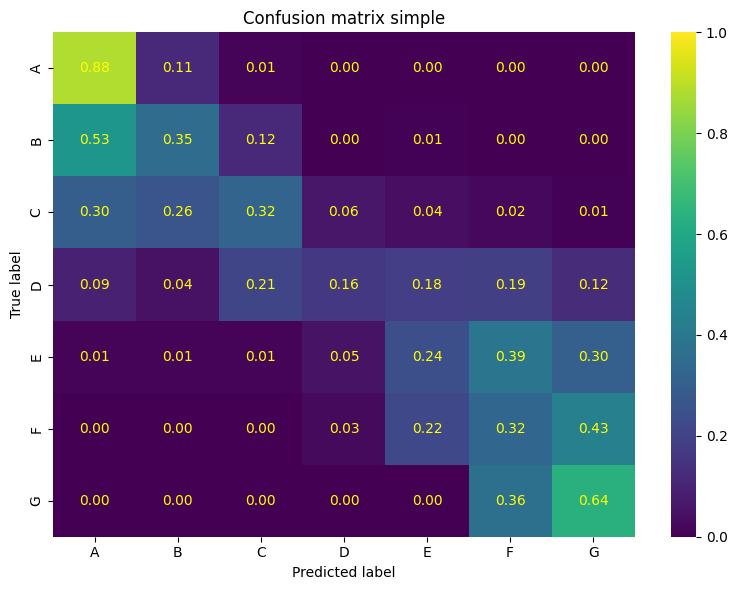

In [11]:
y_pred_ridge_opt = final_model.predict(X_val)
get_results(y_val, y_pred_ridge_opt, target_names)

## Base model without balanced weights

/home/dzsef/.venvs/pandas-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/dzsef/.venvs/pandas-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/dzsef/.venvs/pandas-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

              precision    recall  f1-score   support

           A       0.58      0.62      0.60       364
           B       0.57      0.65      0.60       576
           C       0.53      0.67      0.59       598
           D       0.29      0.20      0.23       290
           E       0.25      0.02      0.03       124
           F       0.00      0.00      0.00        37
           G       0.00      0.00      0.00        11

    accuracy                           0.53      2000
   macro avg       0.32      0.31      0.29      2000
weighted avg       0.49      0.53      0.50      2000



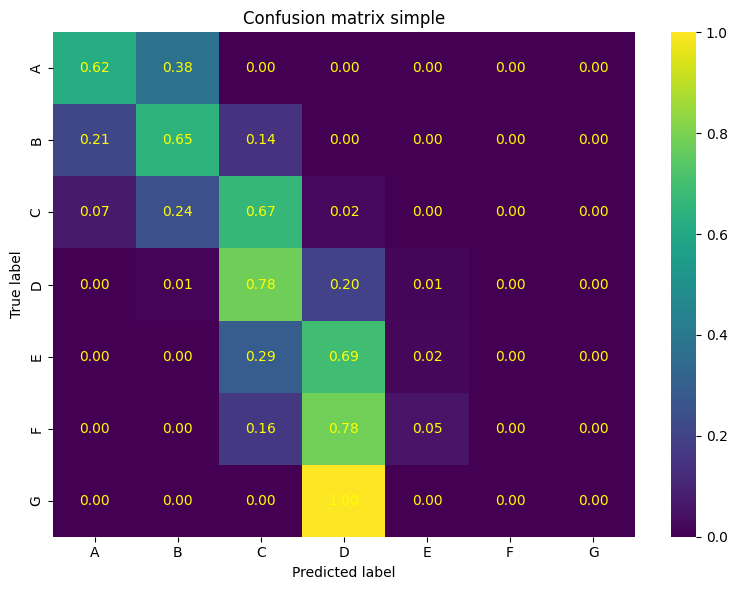

In [13]:
ridge_model_noweights = RidgeClassifier(random_state=42)
ridge_model_noweights.fit(X_train, y_train)

y_pred_ridge = ridge_model_noweights.predict(X_val)

get_results(y_val, y_pred_ridge, target_names)

In [14]:
get_cross_validation_scores(ridge_model_noweights, X_train, y_train )

10-Fold CV Scores: [0.50151526 0.52937946 0.50645504 0.50929535 0.49196641 0.50888826
 0.4721687  0.52245766 0.49769468 0.50449748]
Average f1_weighted Score: 0.5044
Standard Deviation: 0.0150


In [15]:
model_name = 'ridge_noweights'

# Parameters to optimize
param_distributions = {
    'alpha': loguniform(1e-3, 1),
}


random_search = RandomizedSearchCV(
    estimator=ridge_model_noweights,
    param_distributions=param_distributions,
    n_iter=50,  
    cv=5,     
    scoring='f1_weighted',
    random_state=42,
    n_jobs=-1
)
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
df_times.loc[model_name, column_name] = training_time

print(f"Best parameters found: {random_search.best_params_}")
print(f"Best F1-score: {random_search.best_score_:.4f}")

final_model = random_search.best_estimator_

Best parameters found: {'alpha': np.float64(0.22673986523780384)}
Best F1-score: 0.5025


/home/dzsef/.venvs/pandas-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/dzsef/.venvs/pandas-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/dzsef/.venvs/pandas-env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

              precision    recall  f1-score   support

           A       0.58      0.62      0.60       364
           B       0.57      0.65      0.60       576
           C       0.53      0.67      0.59       598
           D       0.29      0.20      0.24       290
           E       0.25      0.02      0.03       124
           F       0.00      0.00      0.00        37
           G       0.00      0.00      0.00        11

    accuracy                           0.53      2000
   macro avg       0.32      0.31      0.29      2000
weighted avg       0.49      0.53      0.50      2000



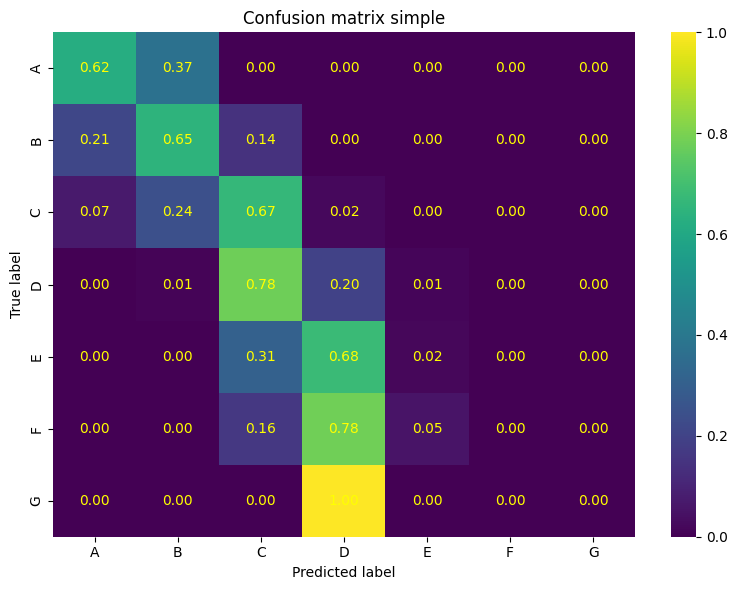

In [16]:
y_pred_ridge_opt = final_model.predict(X_val)
get_results(y_val, y_pred_ridge_opt, target_names)

## Unscaled data

In [17]:
training_data = pd.read_csv("loan-10k.lrn.csv") 
training_data = preprocess_loan_features(training_data)
X_train, X_val, y_train, y_val = prepare_loan_train_test(training_data, scale=False)


              precision    recall  f1-score   support

           A       0.39      0.88      0.54       364
           B       0.50      0.34      0.41       576
           C       0.58      0.32      0.42       598
           D       0.50      0.16      0.24       290
           E       0.27      0.27      0.27       124
           F       0.08      0.30      0.13        37
           G       0.07      0.64      0.13        11

    accuracy                           0.41      2000
   macro avg       0.34      0.42      0.31      2000
weighted avg       0.48      0.41      0.40      2000



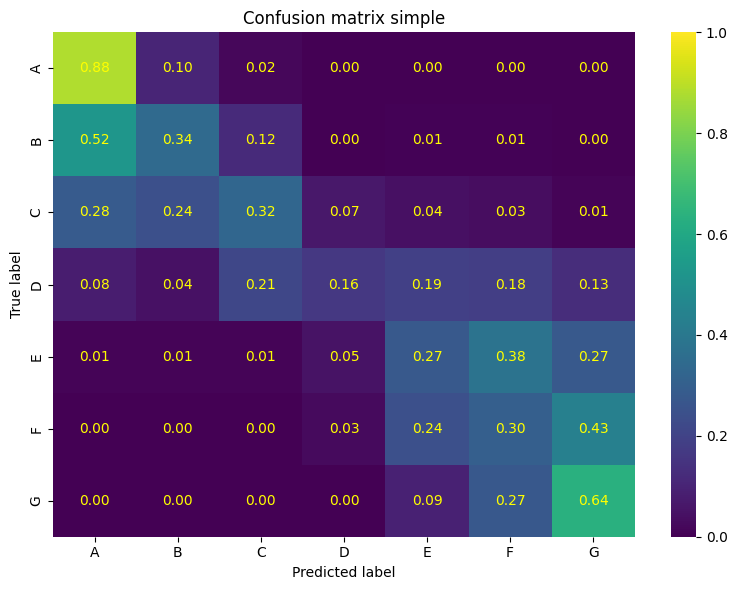

In [18]:
target_names = ["A","B", "C", "D", "E", "F", "G"]
ridge_model = RidgeClassifier(class_weight= 'balanced',random_state=42)
ridge_model.fit(X_train, y_train)

y_pred_ridge = ridge_model.predict(X_val)

get_results(y_val, y_pred_ridge, target_names)

In [19]:
model_name = 'ridge_unscaled'

# Parameters to optimize
param_distributions = {
    'alpha': loguniform(1e-3, 1),
}


random_search = RandomizedSearchCV(
    estimator=ridge_model,
    param_distributions=param_distributions,
    n_iter=50,  
    cv=5,     
    scoring='f1_weighted',
    random_state=42,
    n_jobs=-1
)
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()

training_time = end_time - start_time
df_times.loc[model_name, column_name] = training_time

print(f"Best parameters found: {random_search.best_params_}")
print(f"Best F1-score: {random_search.best_score_:.4f}")

final_model = random_search.best_estimator_

/home/dzsef/.venvs/pandas-env/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.78631e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/dzsef/.venvs/pandas-env/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.89324e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/dzsef/.venvs/pandas-env/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.81087e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/dzsef/.venvs/pandas-env/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.8067e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/dzsef/.venvs/pandas-env/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.95787e-17

Best parameters found: {'alpha': np.float64(0.001378323745500718)}
Best F1-score: 0.3805


/home/dzsef/.venvs/pandas-env/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.1425e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/dzsef/.venvs/pandas-env/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.13877e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/dzsef/.venvs/pandas-env/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.14679e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/dzsef/.venvs/pandas-env/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.20352e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/home/dzsef/.venvs/pandas-env/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=7.25434e-18

              precision    recall  f1-score   support

           A       0.39      0.87      0.54       364
           B       0.49      0.33      0.40       576
           C       0.58      0.32      0.42       598
           D       0.52      0.17      0.25       290
           E       0.26      0.27      0.27       124
           F       0.08      0.30      0.13        37
           G       0.07      0.64      0.13        11

    accuracy                           0.40      2000
   macro avg       0.34      0.42      0.30      2000
weighted avg       0.48      0.40      0.39      2000



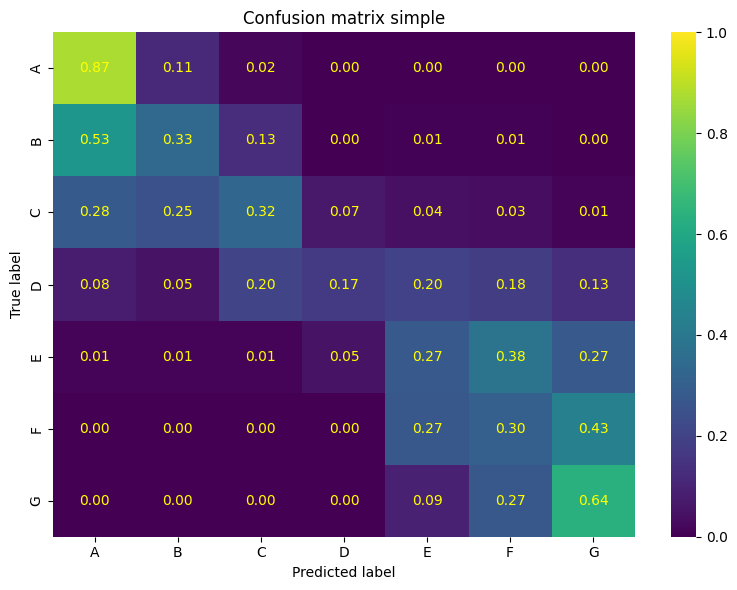

In [20]:
y_pred_ridge_opt = final_model.predict(X_val)
get_results(y_val, y_pred_ridge_opt, target_names)